# Torch Implementation of System Identification

## lib import

### imports

In [1]:
## NN
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# signals
import scipy.signal as signal
import numpy as np
from scipy.io import wavfile
# others
from tqdm import tqdm


In [3]:
a = torch.zeros(10)
print(a)
c = a.to(0)
# print(torch.version.cuda)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


### function define

In [4]:
def lowpass_firwin(ntaps, fc, fs, window='hamming'):
    nyq = 0.5 * fs
    lpf_firwin = signal.firwin(ntaps, fc, nyq=nyq, pass_zero="lowpass", window=window)
    return lpf_firwin

def highpass_firwin(ntaps, fc, fs, window='hamming'):
    nyq = 0.5 * fs
    hpf_firwin = signal.firwin(ntaps, fc, nyq=nyq, pass_zero="highpass",window=window)
    return hpf_firwin

def bandpass_firwin(ntaps, fl, fh,  fs, window='hamming'):
    nyq = 0.5 * fs
    bpf_firwin = signal.firwin(ntaps, [fl, fh], nyq=nyq, pass_zero=False, window=window)
    return bpf_firwin

def bandreject_firwin(ntaps, fl, fh,  fs, window='hamming'):
    nyq = 0.5 * fs
    brf_firwin = signal.firwin(ntaps, [fl, fh], nyq=nyq, window=window)
    return brf_firwin


def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

## Load Data and Data Loader

### Load Dataset (in cpu now)

In [859]:
def dataset_loader(address, index_range):
    input_dict = {}
    print('preparing input audio... ')
    for i in tqdm(range(len(index_range))):
        curr_name = str(index_range[i])
        addr = address + curr_name + '.wav'
        fs, data = wavfile.read('dataset/'+curr_name+'.wav')
        input_dict[i] = data.astype('float64')
    return input_dict, fs

def generate_reference(input_dict, filter_type, ntaps, fs, fc=2000, fl=1000, fh=3000):
    # generate a fir filter
    if filter_type == 'lpf':
        filter_fir = lowpass_firwin(ntaps, fc, fs)
    elif filter_type == 'hpf':
        filter_fir = highpass_firwin(ntaps, fc, fs)
    elif filter_type == 'bpf':
        filter_fir = bandpass_firwin(ntaps, fl, fh, fs)
    elif filter_type == 'brf':
        filter_fir = bandreject_firwin(ntaps, fl, fh, fs)
        
        
    print('preparing reference audio... ')
    NT_1 = ntaps - 1
    reference_dict = {}
    for i in tqdm(range(len(input_dict))):
        input_audio = input_dict[i]
        reference_audio = np.convolve(input_audio, filter_fir, 'full')
        reference_dict[i] =reference_audio[NT_1: -NT_1] # torch.from_numpy(reference_audio).cuda()

    return reference_dict, filter_fir

In [860]:
input_dict, fs = dataset_loader('dataset', np.linspace(1, 60, 60,dtype=int))
reference_dict, filter_fir = generate_reference(input_dict, 'lpf', 32, fs, fc=2000)
N = len(input_dict)
print('number of dataset are: ', N)

preparing input audio... 


100%|██████████| 60/60 [00:00<00:00, 618.29it/s]


preparing reference audio... 


100%|██████████| 60/60 [00:00<00:00, 98.44it/s] 

number of dataset are:  60


Text(0.5, 1.0, 'system impulse response')

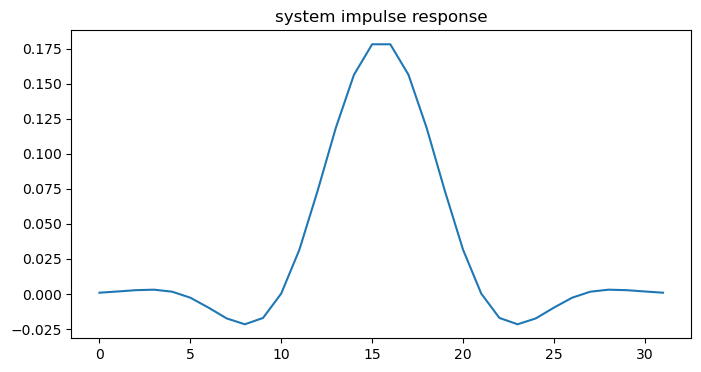

In [861]:
plt.figure(figsize=(8, 4))
plt.plot(filter_fir)
plt.title('system impulse response')

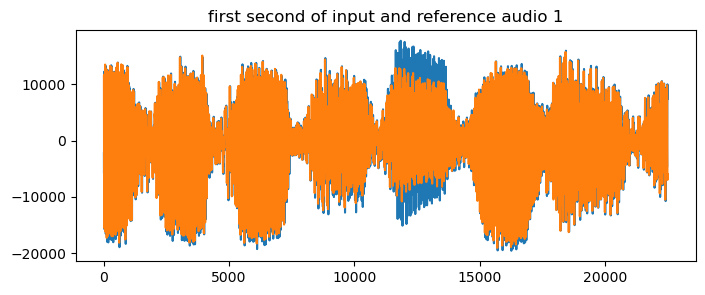

(330750,)
(330719,)


In [862]:
plt.figure(figsize=(8, 3))
plt.plot(input_dict[0][:22500])
plt.plot(reference_dict[0][:22500])
plt.title('first second of input and reference audio 1')
plt.show()

print(input_dict[0].shape)
print(reference_dict[0].shape)

### Make input data and reference data to cuda()

In [863]:
for i in tqdm(range(len(input_dict))):
    input_audio = input_dict[i]
    input_audio_gpu = torch.from_numpy(input_audio).cuda()
    input_dict[i] = input_audio_gpu
    
    reference_audio = reference_dict[i]
    reference_audio_gpu = torch.from_numpy(reference_audio).cuda()
    reference_dict[i] = reference_audio_gpu

100%|██████████| 60/60 [00:00<00:00, 773.89it/s]


### Define data loader

In [799]:
class torch_sysid_loader(Dataset):
    def __init__(self, input_data, reference_data):
        self.input_data = input_data
        self.reference_data = reference_data

    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        return self.input_data[idx:idx+32], self.reference_data[idx]

data_loader_dict = {}
for i in range(N):
    dset = torch_sysid_loader(input_dict[i], reference_dict[i])
    data_loader_dict[i] = DataLoader(dset, batch_size=1, shuffle=False)


In [800]:
print(input_dict[i])

tensor([-3682.,   472.,  3261.,  ..., -4025., -8026., -7447.], device='cuda:0',
       dtype=torch.float64)


## Define Network and Optimizer

### Network

In [804]:
class AF_optimizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(65, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 32)
        
    def forward(self, w):
        w = F.leaky_relu(self.fc1(w))
        w = F.leaky_relu(self.fc2(w))
        w = F.leaky_relu(self.fc3(w))
        w = F.leaky_relu(self.fc4(w))
        w = F.leaky_relu(self.fc5(w))
        w = F.leaky_relu(self.fc6(w))
        w = F.leaky_relu(self.fc7(w))
        w = self.fc8(w)
        
        return w
    
torch_sysid = AF_optimizer().cuda()

### Optimizer and loss

In [851]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(torch_sysid.parameters(), lr=3e-20)

In [852]:
# sample_input = input_dict[0][:32].type(torch.float).requires_grad_()
# sample_reference = reference_dict[0][0].reshape(1).type(torch.float).requires_grad_()
# sample_w = torch.rand(32).cuda().requires_grad_()
# print(sample_input.shape, sample_reference.shape, sample_w.shape)
 
# sample_feed_in = torch.cat((sample_input, sample_reference, sample_w)).type(torch.float).requires_grad_()
# print(sample_feed_in.shape, sample_feed_in)

# sample_out = torch_sysid(sample_feed_in).type(torch.float)
# # print(sample_out)

# optimizer.zero_grad()
# loss = loss_function(torch.dot(sample_input, sample_out).requires_grad_(), sample_reference[0])
# #print(loss.grad_fn)
# loss.backward()

# # print(loss.grad)

# # for param in torch_sysid.parameters():
# #     grad_lst.append(param.grad)
# # print(grad_lst)

## Training (nn-sysid)

In [853]:
loss_lst = []
predict_lst = []

for epoch in range(5):
    print("epoch: ", epoch)
    
    for j in range(N):
        print("audio: ", j)
        # initiate w
        init_w = torch.zeros(65, dtype=torch.float).cuda()
        w = torch_sysid(init_w)
        for i in range(w.shape[0]):
            w[i] = 0.0
            
        # pull out current data loader
        curr_data_loader = data_loader_dict[j]
        
        # backup a 'w' for later observation
        w_back_up = w.clone()
        
        for i, data in tqdm(enumerate(curr_data_loader)):
            # =======================================================================================
            
            # get input and reference data, give it to GPU and adjust dtype
            input_data, reference_data = data  
            
            # make everything in torch.float and to GPU (.cuda())
            input_data = torch.flatten(input_data.type(torch.float))
            reference_data = torch.flatten(reference_data.type(torch.float))     
            
            # cat all needed information (w, input_data, reference_data) to network's input
            network_in = torch.cat((w, input_data, reference_data))
            
            # calculate the output            
            out = torch_sysid(network_in)
            
            # =======================================================================================
            
            # calculate loss and do backward
            optimizer.zero_grad()
            
            predict = torch.dot(input_data, out).clone()
            predict_lst.append(predict.cpu().numpy())
                        
            loss = loss_function(torch.dot(input_data, out), reference_data[0]).requires_grad_()
            # loss.requires_grad = True
            
            loss.backward()
            optimizer.step()
            loss_lst.append(loss.item())              
            w = out.detach().clone()
            
            # =======================================================================================
            
            if i % 10000 == 0:
                print('at iteration:', i * 10000, "current loss is: ", loss.item())    
                grad_lst = []
                for param in torch_sysid.parameters():
                    grad_lst.append(param.grad)
                print(grad_lst)


epoch:  0
audio:  0


47it [00:00, 469.67it/s]

at iteration: 0 current loss is:  2398393856.0
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


10104it [00:15, 697.88it/s]

at iteration: 100000000 current loss is:  5754601984.0
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


20097it [00:29, 698.34it/s]

at iteration: 200000000 current loss is:  42564984.0
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


30102it [00:44, 698.31it/s]

at iteration: 300000000 current loss is:  199219168.0
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


31955it [00:46, 684.25it/s]


KeyboardInterrupt: 

### Training (LMS)

In [845]:
lr = 3e-10
loss_lst = []
predict_lst = []

for epoch in range(5):
    print("epoch: ", epoch)
    
    for j in range(N):
        print("audio: ", j)
        # initiate w (all zero)
        w = torch.zeros(32, dtype=torch.float).cuda()
                    
        # pull out current data loader
        curr_data_loader = data_loader_dict[j]
        
        for i, data in tqdm(enumerate(curr_data_loader)):
            # =======================================================================================
            
            # get input and reference data, give it to GPU and adjust dtype
            input_data, reference_data = data  
            
            # make everything in torch.float and to GPU (.cuda())
            input_data = torch.flatten(input_data.type(torch.float)).cuda()
            reference_data = torch.flatten(reference_data.type(torch.float)).cuda()    
            
            # predict output:
            predict_data = torch.dot(torch.conj(w), input_data)
            
            # calculate error and gradient direction
            error = reference_data - predict_data
            gradient = lr * torch.conj(error) * input_data
            
            loss_lst.append(error[0].cpu())
#             print(loss_lst)
#             print('input data: ', input_data)
#             print('w: ', w)            
#             print('reference data: ', reference_data)
#             print('predict_data: ', predict_data)
#             print('loss: ', error)
            
            # update coefficient
            w += gradient
            
            # record loss
            

epoch:  0
audio:  0


269459it [01:24, 3182.29it/s]


KeyboardInterrupt: 

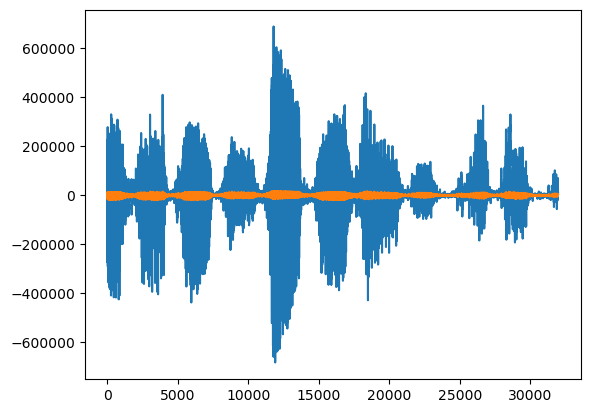

In [854]:
# print(out)
# print(w)
plt.plot(predict_lst)
referece_curr = reference_dict[0][:len(predict_lst)].clone()
referece_curr = referece_curr.cpu().numpy()
input_curr = input_dict[0][:len(predict_lst)].clone()
input_curr = input_curr.cpu().numpy()
plt.plot(input_curr)

In [855]:
# plt.figure()
# plt.plot(loss_lst)
# plt.show()

# plt.figure()
# plt.plot(w.cpu().numpy())
# plt.show()

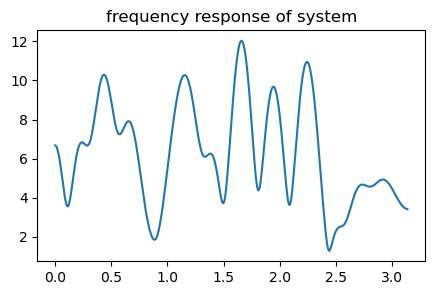

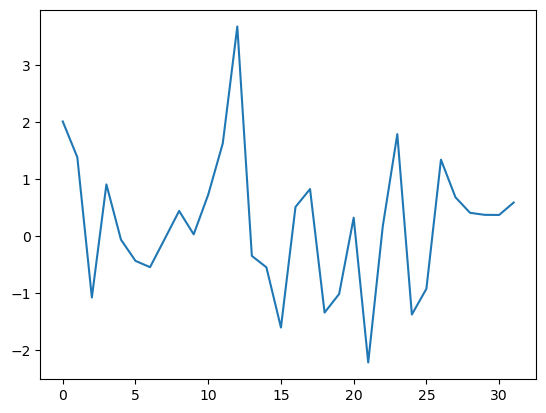

In [856]:
lpf_out = out.detach().clone().cpu()
omega, lpf_out_f = signal.freqz(lpf_out, 1)
plt.figure(figsize=(5, 3))
plt.title("frequency response of system")
plt.plot(omega, np.abs(lpf_out_f))
plt.show()

plt.figure()
plt.plot(lpf_out)
plt.show()

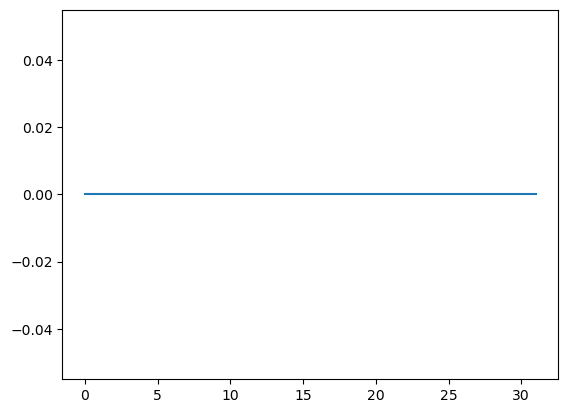

In [817]:
w_back_up = w_back_up.cpu().numpy()
plt.plot(w_back_up)

In [818]:
for param in torch_sysid.parameters():
    print(param.grad)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
